#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель:** Построить модель для предсказания количества заказов такси на следующий час.Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>План проекта:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span<span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование-данных-по-одному-часу" data-toc-modified-id="Ресемплирование-данных-по-одному-часу-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование данных по одному часу</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li></ul></li><li><span><a href="#Подготовка-функций-и-пайплайна" data-toc-modified-id="Подготовка-функций-и-пайплайна-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка функций и пайплайна</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li>

## Загрузка и подготовка данных

In [ ]:
!pip install xgboost lightgbm scikit-learn -q

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.utils import shuffle
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

RANDOM_STATE = 42
TEST_SIZE=0.1

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])
data.sort_index(inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [ ]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Анализ

### Ресемплирование данных по одному часу

In [ ]:
f"Временной промежуток данных: {data.index.min()} - {data.index.max()}"

'Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:50:00'


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Временной промежуток данных охватывает шесть месяцев, с марта по август 2018 года. Это затрудняет анализ сезонности, поскольку для полного понимания сезонных изменений нам нужно больше данных, охватывающих весь год. Без данных за осенне-зимний период и праздники трудно увидеть все сезонные колебания. Для точного анализа сезонности лучше иметь данные за весь год.</p>
</div>

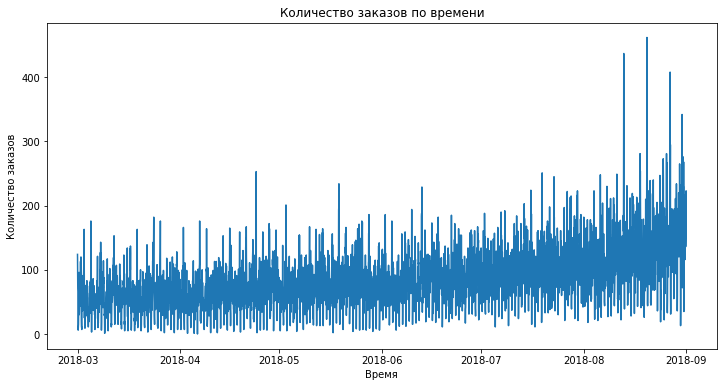

In [ ]:
data = data.resample('H').sum()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['num_orders'])
plt.title('Количество заказов по времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show()

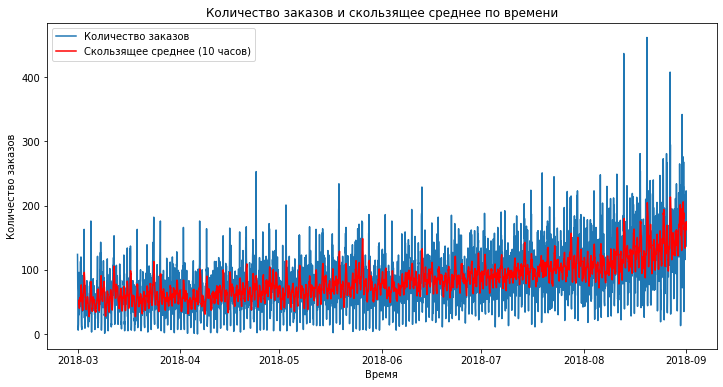

In [ ]:
df = data.copy()
df['rolling_mean'] = data['num_orders'].rolling(window=10).mean()

plt.figure(figsize=(12, 6))
plt.plot(data.index, df['num_orders'], label='Количество заказов')
plt.plot(data.index, df['rolling_mean'], label='Скользящее среднее (10 часов)', color='red')
plt.title('Количество заказов и скользящее среднее по времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

### Тренды и сезонность

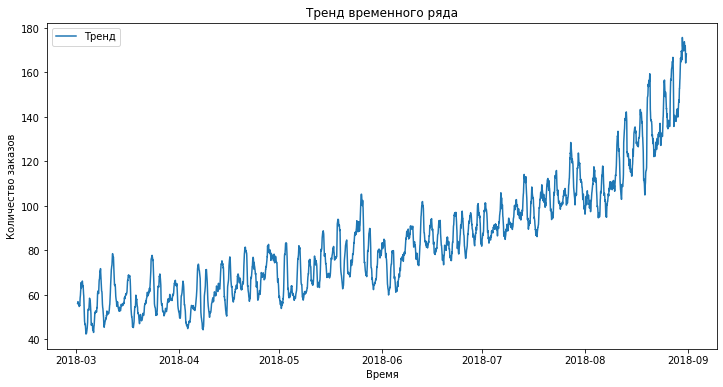

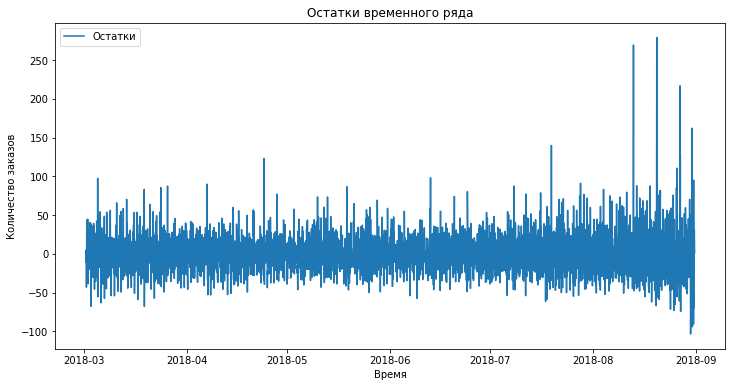

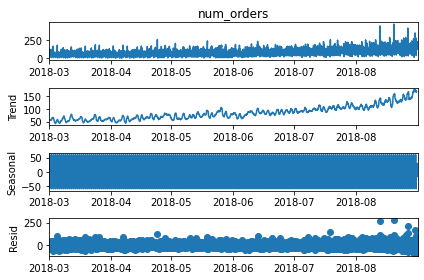

In [ ]:
result = seasonal_decompose(data['num_orders'], model='additive')

plt.figure(figsize=(12, 6))
sns.lineplot(x=result.trend.index, y=result.trend, label='Тренд')
plt.title('Тренд временного ряда')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=result.resid.index, y=result.resid, label='Остатки')
plt.title('Остатки временного ряда')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()


result.plot()
plt.show()

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Проанализируем информацию о часах, днях и месяцах</p>
</div>

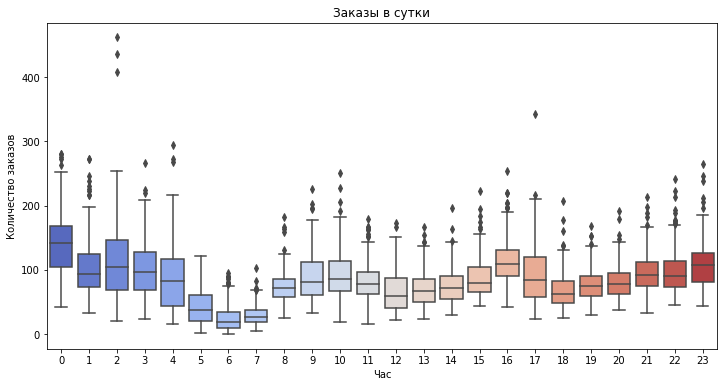

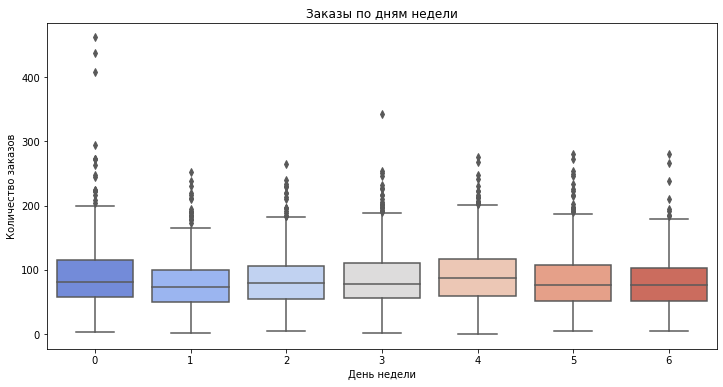

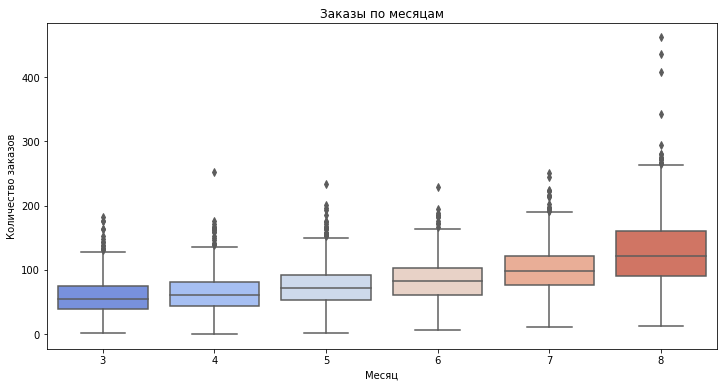

In [ ]:
df = data.copy()
df['hour'] = data.index.hour
df['day_of_week'] = data.index.dayofweek
df['month'] = data.index.month


plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='num_orders', data=df, palette='coolwarm')
plt.title('Заказы в сутки')
plt.xlabel('Час')
plt.ylabel('Количество заказов')
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='num_orders', data=df, palette='coolwarm')
plt.title('Заказы по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='num_orders', data=df, palette='coolwarm')
plt.title('Заказы по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>

Проанализировав графики с историческими данными о заказах такси, можно сделать следующие выводы:

1. Тренд: В течение рассматриваемого периода наблюдается устойчивый рост числа заказов.

2. Сезонность: На основе данных с марта по август видно, что август — месяц с наибольшим числом заказов такси.

3. Дни недели: Заказы такси наиболее часты в понедельник и пятницу. При этом в понедельник также наблюдаются выбросы, что может указывать на необычные или экстремальные значения заказов в этот день.

4. Время суток: Спрос на такси в течение дня колеблется с несколькими пиками. Например, в 6 утра спрос на такси является самым низким, что может быть связано с тем, что ранним утром многие люди еще не начали активно передвигаться. Пики спроса наблюдаются в более п обслуживания.живания.</p>
</div>

## Подготовка функций и пайплайна

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
make_features(data, 6, 6)

In [ ]:
cat_col = ['hour', 'day', 'dayofweek']
data[cat_col] = data[cat_col].astype('category')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   num_orders    4416 non-null   int64   
 1   hour          4416 non-null   category
 2   day           4416 non-null   category
 3   dayofweek     4416 non-null   category
 4   lag_1         4415 non-null   float64 
 5   lag_2         4414 non-null   float64 
 6   lag_3         4413 non-null   float64 
 7   lag_4         4412 non-null   float64 
 8   lag_5         4411 non-null   float64 
 9   lag_6         4410 non-null   float64 
 10  rolling_mean  4410 non-null   float64 
dtypes: category(3), float64(7), int64(1)
memory usage: 325.8 KB


In [ ]:
ohe_columns = ['hour','day','dayofweek']
num_columns = ['rolling_mean']+ [f'lag_{i}' for i in range(1, 7)]

ohe_pipe = Pipeline([
    ('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)
models = {
    'Linear Regression': LinearRegression(),
    'CatBoost': CatBoostRegressor(loss_function='RMSE',
                                  logging_level='Silent',
                                  random_state=RANDOM_STATE),
    'LightGBM': lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE , verbose=-1),
    'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE )
}
param_grid = {
    'Linear Regression': {
        'model__fit_intercept': [True, False]
    },
    'CatBoost': {
        'model__n_estimators': [50, 100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__depth': [3, 5, 7, 10]
    },
    'LightGBM': {
        'model__n_estimators': [50, 100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__num_leaves': [31, 63, 127, 255]
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 150, 200],
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10]
    }
}


## Обучение

In [ ]:
make_features(data, 6, 6)

train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
test = test.dropna()

X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

best_models = {}
for name, model in models.items():
    print(f'\nПодбор гиперпараметров для {name}')

    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', model)
    ])

    timecv = TimeSeriesSplit(n_splits=5)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid[name],
        cv=timecv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    best_score = np.sqrt(-grid_search.best_score_)
    print(f'{name} RMSE на кросс-валидации: {best_score:.2f}')
    print(f'Лучшие гиперпараметры для {name}: {grid_search.best_params_}')

**Подбор гиперпараметров для моделей и их результаты**

Подбор гиперпараметров для Linear Regression
- Linear Regression RMSE на кросс-валидации: 27.13
- Лучшие гиперпараметры для Linear Regression: {'model__fit_intercept': True}

Подбор гиперпараметров для CatBoost
- CatBoost RMSE на обучающей выборке: 26.23
- Лучшие гиперпараметры для CatBoost: {'model__depth': 3, 'model__learning_rate': 0.2, 'model__n_estimators': 150}

Подбор гиперпараметров для LightGBM
- LightGBM RMSE на обучающей выборке: 27.36
- Лучшие гиперпараметры для LightGBM: {'model__learning_rate': 0.05, 'model__n_estimators': 100, 'model__num_leaves': 31}

Подбор гиперпараметров для Random Forest
- Random Forest RMSE на обучающей выборке: 26.66
- Лучшие гиперпараметры для Random Forest: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Лучшая модель Random Forest. Проведем тестирование для этой модели и сравним ее качество с константной.  </p>
</div>

## Тестирование

In [ ]:
pipeline_rf = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', CatBoostRegressor(loss_function='RMSE',
                                  logging_level='Silent',
                                  random_state=RANDOM_STATE))
])

param_grid_rf = {'model__depth': [3],
                 'model__learning_rate': [0.2],
                 'model__n_estimators': [150]}

timecv = TimeSeriesSplit(n_splits=5)
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=timecv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print(f'Лучшие гиперпараметры для CatBoost : {best_params_rf}')


best_model_rf = grid_search_rf.best_estimator_
y_test_pred = best_model_rf.predict(X_test)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'CatBoost  RMSE на тестовой выборке: {rmse_test_rf:.2f}')

Лучшие гиперпараметры для CatBoost : {'model__depth': 3, 'model__learning_rate': 0.2, 'model__n_estimators': 150}
CatBoost  RMSE на тестовой выборке: 45.78


In [ ]:
def dummy_model(y_train, y_test):
    last_value = y_train.iloc[-1]
    y_test_pred = np.full_like(y_test, last_value, dtype=np.float64)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    return rmse_test
dummy_rmse = dummy_model(y_train, y_test)
print(f'RMSE dummy модели: {dummy_rmse:.2f}')

## Общий вывод

В рамках проекта по прогнозированию числа заказов такси были выполнены следующие этапы:

1. Подготовка данных:
   - Данные о заказах такси были загружены и ресемплированы по часам.
   - Были созданы новые признаки, такие как лаговые признаки и скользящее среднее, для улучшения модели.

2. Обучение моделей:
   - Проведена настройка гиперпараметров для различных моделей машинного обучения, включая Linear Regression, CatBoost, LightGBM и RandomForest.
   - Для выбора лучших гиперпараметров использовалась кросс-валидация с использованием GridSearchCV.

3. Проверка качества моделей:
   - Модели были обучены на тренировочной выборке и проверены на тестовой выборке.
   - Оценка производилась с помощью метрики RMSE.

4. Сравнение с дамми моделью:
   - Для проверки эффективности выбранной модели был использован константный прогноз.
   - Сравнение показало, что модель CatBoost превосходит константную модель по качеству прогноза.

Выводы:

- CatBoost была выбрана как наиболее эффективная модель, обеспечившая наилучшие результаты по метрике RMSE на тестовой выборке.
- Модель CatBoost продемонстрировала лучшие результаты по сравнению с константной моделью, что подтверждает её высокую предсказательную способность и соответствие требованиям заказчиков.

Проект показал, что использование модели CatBoost для прогнозирования числа заказов такси является эффективным и надежным решением.